In [64]:
import os
import pandas as pd
import matplotlib.pyplot as plt

In [65]:
# load all csv to one big df

data_dir = 'data/in'
file_list = os.listdir(data_dir)
all_dfs = []

for file_name in file_list:
    if file_name.endswith('.csv'):
        file_path = os.path.join(data_dir, file_name)
        
        total_df = pd.read_csv(file_path)
        all_dfs.append(total_df)

total_df = pd.concat(all_dfs)
print(total_df.head())


                         started_at                          ended_at  \
0  2024-02-01 04:15:31.355000+00:00  2024-02-01 04:24:47.874000+00:00   
1  2024-02-01 04:28:55.316000+00:00  2024-02-01 04:32:30.956000+00:00   
2  2024-02-01 04:54:51.455000+00:00  2024-02-01 04:58:49.535000+00:00   
3  2024-02-01 04:55:59.878000+00:00  2024-02-01 04:58:36.073000+00:00   
4  2024-02-01 04:57:49.630000+00:00  2024-02-01 05:04:14.871000+00:00   

   duration  start_station_id           start_station_name  \
0       556               808            Damsgårdsveien 71   
1       215                58                    Tårnplass   
2       238               816  Østre Murallmenningen nedre   
3       156               794             St. Jakobs Plass   
4       385               817    Nedre Korskirkeallmenning   

            start_station_description  start_station_latitude  \
0  By walkway to Damsgårdsveien 69-71               60.380263   
1             Tårnplass ved Tinghuset               60.393

In [66]:
# create df describing stations and how many trips from one station was made to another

# duration numeric to calculate
total_df['duration'] = pd.to_numeric(total_df['duration'])

# new df with average duration per start station
avg_duration_df = total_df.groupby('start_station_name')['duration'].mean().reset_index()
avg_duration_df.rename(columns={'duration': 'avg_duration'}, inplace=True)

# df that counts how many times a cycle drove from
# a start station to all other stations
trips_to_other_stations_df = total_df.groupby(['start_station_name', 'end_station_name']).size().reset_index()
trips_to_other_stations_df.rename(columns={0: 'trips'}, inplace=True)

# pivot this DataFrame to have a tripl count from each start_station_name to each end_station_name
pivot_df = trips_to_other_stations_df.pivot(index='start_station_name', columns='end_station_name', values='trips').reset_index()

# NaN values to 0 (no trip from there to there)
pivot_df.fillna(0, inplace=True)

final_df = pd.merge(avg_duration_df, pivot_df, on='start_station_name')

print(final_df.head())
final_df.to_csv("data/out/stations_trips_df.csv", index=False)

       start_station_name  avg_duration  AdO arena  Akvariet  \
0               AdO arena    480.240051       16.0      17.0   
1                Akvariet    535.961399       14.0       5.0   
2       Allehelgens plass    506.443609       34.0      18.0   
3  Amalie Skrams vei Nord    688.176923        0.0       0.0   
4   Amalie Skrams vei Sør    770.327189       19.0       3.0   

   Allehelgens plass  Amalie Skrams vei Nord  Amalie Skrams vei Sør  \
0               52.0                     0.0                    1.0   
1               38.0                     0.0                    2.0   
2                7.0                     2.0                    3.0   
3                0.0                     2.0                   14.0   
4                2.0                    19.0                    5.0   

   Bergen Jernbanestasjon II  Bergen jernbanestasjon  Bjørnsonsgate  ...  \
0                       25.0                    40.0            4.0  ...   
1                        4.0        

In [67]:
# Get unique station info from start stations
start_stations_df = total_df[['start_station_id','start_station_name','start_station_description','start_station_latitude','start_station_longitude']].drop_duplicates()

# Renaming columns 
start_stations_df.columns = ['station_id', 'station_name', 'station_description', 'station_latitude', 'station_longitude']

# Get unique station info from end stations
end_stations_df = total_df[['end_station_id','end_station_name','end_station_description','end_station_latitude','end_station_longitude']].drop_duplicates()

# Renaming columns 
end_stations_df.columns = ['station_id','station_name','station_description','station_latitude','station_longitude']

# Concatenate two station dataframes and drop duplicates (as some stations could be in both start and end station list)
all_stations_df = pd.concat([start_stations_df, end_stations_df]).drop_duplicates()

all_stations_df.to_csv("data/out/stations_df.csv", index=False)
print(all_stations_df.head())

   station_id                 station_name  \
0         808            Damsgårdsveien 71   
1          58                    Tårnplass   
2         816  Østre Murallmenningen nedre   
3         794             St. Jakobs Plass   
4         817    Nedre Korskirkeallmenning   

                  station_description  station_latitude  station_longitude  
0  By walkway to Damsgårdsveien 69-71         60.380263           5.323223  
1             Tårnplass ved Tinghuset         60.393755           5.321792  
2                 Ved inngang Gågaten         60.395144           5.320002  
3            Langs Folkeuniversitetet         60.386681           5.330978  
4         Nedre Korskirkeallmenning 8         60.394550           5.327050  


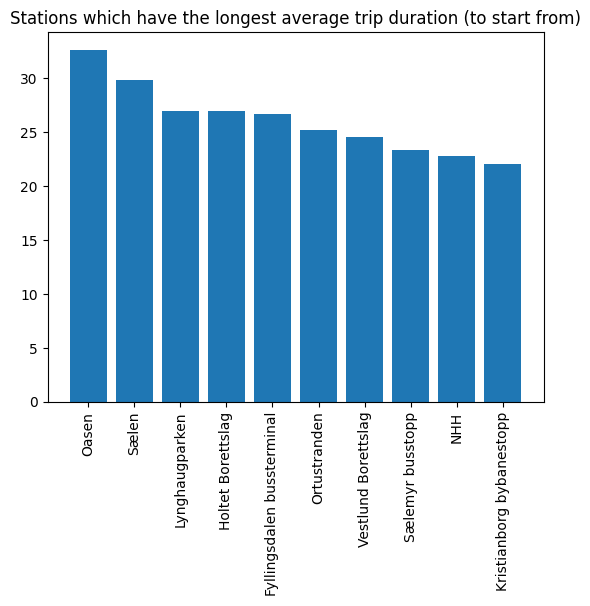

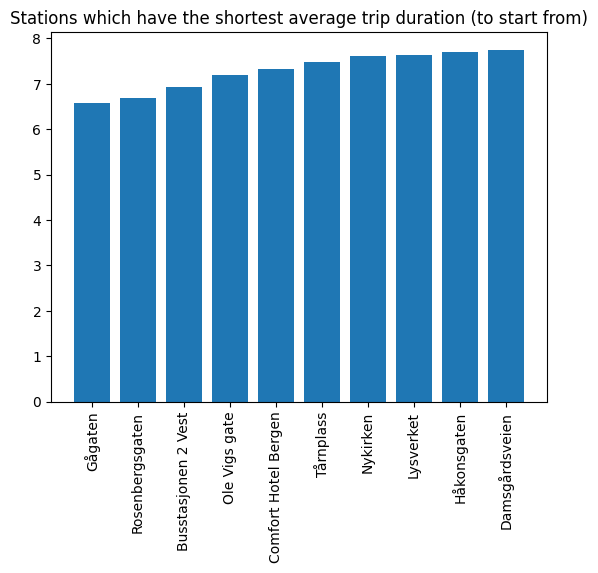

In [68]:
df_longest_trips = final_df.nlargest(10, 'avg_duration')

plt.xticks(rotation='vertical')
plt.bar(df_longest_trips['start_station_name'], df_longest_trips['avg_duration']/60)
plt.title('Stations which have the longest average trip duration (to start from)')
plt.show()
plt.clf()

df_shortest_trips = final_df.nsmallest(10, 'avg_duration')

plt.xticks(rotation='vertical')
plt.bar(df_shortest_trips['start_station_name'], df_shortest_trips['avg_duration']/60)
plt.title('Stations which have the shortest average trip duration (to start from)')
plt.show()

In [91]:
import plotly.graph_objects as go

fig = go.Figure()

# Get base station (in this example, we're using the first station as the base)
base_station_name = all_stations_df.iloc[0]["station_name"]


# Filter trips to other stations from the base station
trips_from_base = trips_to_other_stations_df[trips_to_other_stations_df['start_station_name'] == base_station_name]

# Loop through all other stations
for i in range(len(all_stations_df)):
    if all_stations_df.iloc[i]['station_name'] != base_station_name:  # if the station is not the base station
        target_station_name = all_stations_df.iloc[i]['station_name']
        # Get the number of trips from base station to the current station
        num_trips = trips_from_base[trips_from_base['end_station_name'] == target_station_name]['trips'].values[0] if target_station_name in trips_from_base['end_station_name'].values else 0

        fig.add_trace(go.Scattermapbox(
            mode = "lines",
            lon = [all_stations_df[all_stations_df['station_name'] == base_station_name]['station_longitude'].values[0], all_stations_df.iloc[i]['station_longitude']],
            lat = [all_stations_df[all_stations_df['station_name'] == base_station_name]['station_latitude'].values[0], all_stations_df.iloc[i]['station_latitude']],
            ))

        # Add an invisible marker at the midpoint of each line with the desired hover text
        fig.add_trace(go.Scattermapbox(
            mode = 'markers',
            lon = [(all_stations_df[all_stations_df['station_name'] == base_station_name]['station_longitude'].values[0] + all_stations_df.iloc[i]['station_longitude']) / 2],
            lat = [(all_stations_df[all_stations_df['station_name'] == base_station_name]['station_latitude'].values[0] + all_stations_df.iloc[i]['station_latitude']) / 2],
            marker = go.scattermapbox.Marker(
                size = 0
            ),
            hovertemplate = f'Trips from {base_station_name} to {target_station_name}: {num_trips}'))

fig.add_trace(
    go.Scattermapbox(
        mode = 'markers',
        lon = all_stations_df['station_longitude'],
        lat = all_stations_df['station_latitude'],
        marker = go.scattermapbox.Marker(
            size = 8
        ),
        text = all_stations_df['station_name'],
        hoverinfo = 'text'
    )
)

fig.update_layout(
    margin ={'l':0,'t':0,'b':0,'r':0},
    mapbox = {
        'style': "open-street-map",
        'center': {
            'lon': all_stations_df[all_stations_df['station_name'] == base_station_name]['station_longitude'].values[0],
            'lat': all_stations_df[all_stations_df['station_name'] == base_station_name]['station_latitude'].values[0]
        }, 
        'zoom': 10
    }
)

fig.show()